In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
import tqdm
import matplotlib.pyplot as plt
import timm
#torch
import torch
import math
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from torch.optim import Adam, lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler

#모델링 코드

In [2]:
data = pd.read_csv('data.csv')
data=data.iloc[:,2:]
data

,img,labels
0,yg/rose/rose_3_isolate.jpg,yg
1,yg/rose/rose_2_isolate.jpg,yg
2,yg/rose/rose_1_isolate.jpg,yg
3,yg/rose/rose_5_isolate.jpg,yg
4,yg/rose/rose_4_isolate.jpg,yg
...,...,...
2897,sm/irin/irin_121_isolate.jpg,sm
2898,sm/irin/irin_124_isolate.jpg,sm
2899,sm/irin/irin_126_isolate.jpg,sm
2900,sm/irin/irin_138_isolate.jpg,sm


In [3]:
n_classes = len(set(data['labels']))
labels_lut = {i:num for num,i in enumerate(set(data['labels']))}

In [4]:
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
import cv2
n_iter=0
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(data['img'], data['labels']):
            #print(n_iter)
            n_iter+=1
            #print(train_index)
            #print(test_index)
import os
import torch
from PIL import Image
from torch.utils.data import Dataset

class PlantPathologyDataset(Dataset):
    def __init__(
        self,
        path_csv: str = 'data.csv',
        mode: str = 'train',
        transforms = None,
        split: float = 0.8,
    ):
        self.transforms = transforms
        self.mode = mode
        self.data = pd.read_csv(path_csv)
        labels_all = list( self.data['labels'])
        self.labels_lut = labels_lut

        # split dataset
        self.data = self.data.sample(frac=1).reset_index(drop=True)
        self.data = self.data.iloc[train_index] if self.mode == 'train' else self.data.iloc[test_index]
        self.img_names = list(self.data['img'])
        self.labels = list(self.data['labels'])
    def num_classes():
        return len(set(self.labels))
    def to_one_hot(self, labels: str) -> tuple:
        return int(self.labels_lut[labels])

    def __getitem__(self, idx: int) -> tuple:
        img_path = self.img_names[idx]
        label = self.to_one_hot(self.labels[idx])
        img = plt.imread(img_path)

        # augmentation
        if self.transforms:
            img = self.transforms(Image.fromarray(img))
        return img, torch.tensor(label)

    def __len__(self) -> int:
        return len(self.data)

# ==============================
# ==============================

dataset = PlantPathologyDataset()
# quick view
# fig = plt.figure(figsize=(9, 6))
# for i in range(9):
#     img, lb = dataset[i]
#     ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
#     ax.imshow(img)
#     ax.set_title(lb)

In [5]:
train_data = data.iloc[train_index,]
test_data=data.iloc[test_index,]

In [6]:
test_data.to_csv('test_data.csv')

In [7]:
from torchvision import transforms as T
TRAIN_TRANSFORM = T.Compose([
    T.Resize((224,224)),
    # T.RandomPerspective(),
    # T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    # T.RandomVerticalFlip(),
    # T.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    # T.RandomInvert(),
    T.ToTensor(),
    # T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    # T.Normalize([0.431, 0.498,  0.313], [0.237, 0.239, 0.227]),  # custom
])

VALID_TRANSFORM = T.Compose([
    T.Resize((224,224)),
    # T.CenterCrop(224),
    T.ToTensor(),
    # T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    # T.Normalize([0.431, 0.498,  0.313], [0.237, 0.239, 0.227]),  # custom
])

training dataset: 2322
test dataset: 580
batch labels: 182
image size: torch.Size([3, 224, 224])
<class 'torch.Tensor'>


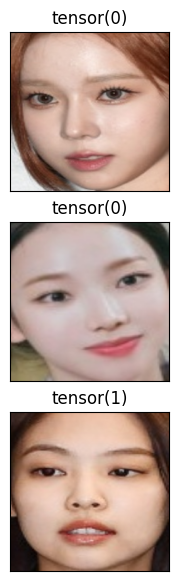

In [8]:
import multiprocessing as mproc
import pytorch_lightning as pl
from torch.utils.data import DataLoader

class PlantPathologyDM(pl.LightningDataModule):
    dataset_cls = PlantPathologyDataset

    def __init__(
        self,
        path_csv: str = 'data.csv',
        path_img_dir: str = 'train_images',
        batch_size: int = 128,
        num_workers: int = None,
    ):
        super().__init__()
        self.path_csv = path_csv
        self.path_img_dir = path_img_dir
        self.batch_size = batch_size
        self.num_workers = num_workers if num_workers is not None else mproc.cpu_count()
        self.train_dataset = None
        self.test_dataset = None

    def prepare_data(self):
        pass

    @property
    def num_classes(self) -> int:
        assert self.train_dataset and self.test_dataset
        return max(self.train_dataset.num_classes, self.test_dataset.num_classes)

    def setup(self, stage=None):
        self.train_dataset = self.dataset_cls(self.path_csv, mode='train', transforms=TRAIN_TRANSFORM)
        print(f"training dataset: {len(self.train_dataset)}")
        self.test_dataset = self.dataset_cls(self.path_csv, mode='test', transforms=VALID_TRANSFORM)
        print(f"test dataset: {len(self.test_dataset)}")

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )


    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

# ==============================
# ==============================

dm = PlantPathologyDM()
dm.setup()


# quick view
fig = plt.figure(figsize=(3, 7))
for imgs, lbs in dm.train_dataloader():
    print(f'batch labels: {torch.sum(lbs, axis=0)}')
    print(f'image size: {imgs[0].shape}')
    print(type(imgs))
    for i in range(3):
        ax = fig.add_subplot(3, 1, i + 1, xticks=[], yticks=[])
        # print(np.rollaxis(imgs[i].numpy(), 0, 3).shape)
        ax.imshow(np.rollaxis(imgs[i].numpy(), 0, 3))
        ax.set_title(lbs[i])
    break

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cuda


In [10]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [11]:
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))

        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

In [21]:
class ShopeeNet(nn.Module):

    def __init__(self,
                 n_classes,
                 model_name='vit_base_patch16_224',
                 use_fc=False,
                 fc_dim=512,
                 dropout=0.0,
                 s=30.0,
                 margin=0.50,
                 ls_eps=0.0,
                 theta_zero=0.785,
                 pretrained=True):
        """
        :param n_classes:
        :param model_name: name of model from pretrainedmodels
            e.g. resnet50, resnext101_32x4d, pnasnet5large
        :param pooling: One of ('SPoC', 'MAC', 'RMAC', 'GeM', 'Rpool', 'Flatten', 'CompactBilinearPooling')
        :param loss_module: One of ('arcface', 'cosface', 'softmax')
        """
        super(ShopeeNet, self).__init__()
        print('Building Model Backbone for {} model'.format(model_name))

        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        final_in_features = self.backbone.head.in_features

        self.backbone.head = nn.Identity()
        self.pooling =  nn.AdaptiveAvgPool2d(1)

        self.use_fc = use_fc
        if use_fc:
            self.dropout = nn.Dropout(p=dropout)
            self.fc = nn.Linear(final_in_features, fc_dim)
            self.bn = nn.BatchNorm1d(fc_dim)
            self._init_params()
            final_in_features = fc_dim

        self.final = nn.Linear(final_in_features, n_classes)

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, x):
        feature = self.extract_feat(x)
        logits = self.final(feature)
        #logits = None
        return feature, logits

    def extract_feat(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)
        #x = self.pooling(x).view(batch_size, -1)
        #print(final_in_features)
        if self.use_fc:
            x = self.dropout(x)
            x = self.fc(x)
            x = self.bn(x)

        return x

In [13]:
def train_fn(dataloader,model,criterion,optimizer,device,scheduler,epoch):
    model.train()
    loss_score = AverageMeter()

    tk0 = tqdm.tqdm(enumerate(dataloader), total=len(dataloader))
    for bi,d in tk0:

        batch_size = d[0].shape[0]


        images = d[0]
        targets = d[1]

        images = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        _,output = model(images,targets)
        loss = criterion(output,targets)

        loss.backward()
        optimizer.step()

        loss_score.update(loss.detach().item(), batch_size)
        tk0.set_postfix(Train_Loss=loss_score.avg,Epoch=epoch)


    return loss_score

In [14]:
def eval_fn(data_loader,model,criterion,device):

    loss_score = AverageMeter()

    model.eval()
    tk0 = tqdm.tqdm(enumerate(data_loader), total=len(data_loader))

    with torch.no_grad():

        for bi,d in tk0:
            batch_size = d[0].size()[0]

            image = d[0]
            targets = d[1]

            image = image.to(device)
            targets = targets.to(device)
            _,output = model(image,targets)

            loss = criterion(output,targets)

            loss_score.update(loss.detach().item(), batch_size)
            tk0.set_postfix(Eval_Loss=loss_score.avg)

    return loss_score

In [15]:
import torch
torch.cuda.current_device()
torch.cuda.is_available()

True

In [ ]:
import torch.nn as nn
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss()(inputs, targets)

        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
              return torch.mean(F_loss)
        else:
              return F_loss

In [16]:
os.environ["CUDA_VISIBLE_DEVICES"]= "6,7,8,9"
foldperf= {}
from torch.utils.data import SubsetRandomSampler
import torch.optim as optim
criterion = FocalLoss()
model = ShopeeNet(fc_dim=512, n_classes=n_classes, s=20, margin=0.5,ls_eps=0.0,theta_zero=0.785)
model= model.to(device)
num_epochs = 30
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
for fold, (train_idx,val_idx) in enumerate(skf.split(train_data['img'], train_data['labels'])):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(PlantPathologyDataset(mode='train', transforms=TRAIN_TRANSFORM), batch_size=64, sampler=train_sampler,num_workers=1)
    test_loader = DataLoader(PlantPathologyDataset(mode='train', transforms=VALID_TRANSFORM), batch_size=64, sampler=test_sampler,num_workers=1)


    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}
    best_loss = 1000000
    for epoch in range(num_epochs):
        train_loss=train_fn(train_loader, model, criterion, optimizer, device, scheduler = scheduler, epoch = epoch)
        test_loss= eval_fn(test_loader, model, criterion, device)
        scheduler.step()
        if test_loss.avg < best_loss:
            torch.save(model,'final.pt')
            best_loss = test_loss.avg


        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)


    foldperf['fold{}'.format(fold+1)] = history

Building Model Backbone for vit_base_patch16_224 model
Fold 1


100%|█████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.35it/s, Eval_Loss=1.52]
/home/anniy8920/.conda/envs/pytorch/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
 93%|████████████████████████████████████████████████████▎   | 28/30 [00:27<00:01,  1.01it/s, Epoch=37, Train_Loss=1.34]


KeyboardInterrupt: 

In [23]:
labels_lut

{'sm': 0, 'yg': 1, 'hybe': 2, 'jyp': 3}

In [28]:
model2=torch.load('final.pt')
model2.eval()
preds = []
dm.batch_size = 32
total_batch = int(580/dm.batch_size)
for i in range(total_batch):
    for imgs, names in dm.test_dataloader():
            with torch.no_grad():
                imgs=imgs.cuda()
                _,logits = model2(imgs)
            #print(np.round(encode.cpu().numpy(), decimals=2))
            for be, name in zip(logits,names ):#여기서 be는 encode 원소들 즉, 예측결과
                #count= count_frequency(np.round(be.cpu().numpy(), decimals=2))
                # if 1.0 in count.keys() and count[1.0]==2 :
                #         temp=np.argpartition(be.cpu().detach().numpy(), -2)[-2:]
                #         lbs=int(name.numpy()) if name.numpy() in temp else temp[0]
                lbs=np.argmax(be.cpu().detach().numpy())
                preds.append(dict(labels=int(name.numpy()), predict=lbs))
            break

df_preds = pd.DataFrame(preds)
print(df_preds.head())

   labels  predict
0       3        0
1       0        0
2       2        0
3       0        0
4       0        0


In [29]:
data = {'y_Actual':    list(df_preds['labels'].values),
        'y_Predicted': list(df_preds['predict'].values),
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
print (df)

     y_Actual  y_Predicted
0           3            0
1           0            0
2           2            0
3           0            0
4           0            0
..        ...          ...
571         3            0
572         0            0
573         1            0
574         0            0
575         3            0

[576 rows x 2 columns]


In [30]:
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted    0
Actual        
0          144
1          126
2           72
3          234


In [ ]:
import gc

embeds = []

my_model = ShopeeNet(n_classes=4,model_name='vit_large_patch14_clip_224.openai',pretrained=False)

model = torch.load('k_cross_CNN.pt')
my_model.load_state_dict(model.state_dict(),strict=False)
my_model = my_model.to(device)
my_model.eval()
image_dataset = PlantPathologyDataset(mode='test', transforms=VALID_TRANSFORM)
image_loader = torch.utils.data.DataLoader(
    image_dataset,
    batch_size=8,
    pin_memory=True,
    drop_last=False)
val_correct=0
for img,label in tqdm.tqdm(image_loader):
    img = img.to(device)
    label = label.to(device)
    feat, _ = my_model(img,label)
    image_embeddings = feat.detach().cpu().numpy()
    embeds.append(image_embeddings)

del model
image_embeddings = np.concatenate(embeds)
print(f'Our image embeddings shape is {image_embeddings.shape}')
del embeds
gc.collect()


In [ ]:
embeddings = np.load('embeddings.npy')
df = pd.read_csv('test_data.csv')

In [ ]:
def f1_score(y_true, y_pred):
    y_true = y_true.apply(lambda x: set(x.split()))
    y_pred = y_pred.apply(lambda x: set(x.split()))
    intersection = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    len_y_pred = y_pred.apply(lambda x: len(x)).values
    len_y_true = y_true.apply(lambda x: len(x)).values
    f1 = 2 * intersection / (len_y_pred + len_y_true)
    return f1

In [ ]:
!pip install sklearn

In [ ]:
from sklearn.neighbors import NearestNeighbors
KNN= 30
image = True
model = NearestNeighbors(n_neighbors = KNN)
model.fit(embeddings)
distances, indices = model.kneighbors(embeddings)

# Iterate through different thresholds to maximize cv, run this in interactive mode, then replace else clause with a solid threshold
if True:
    if image:
        thresholds = list(np.arange(0,1,0.1))
    else:
        thresholds = list(np.arange(0.1, 1, 0.1))
    scores = []
    for threshold in thresholds:
        predictions = []
        for k in range(embeddings.shape[0]):
            idx = np.where(distances[k,] < threshold)[0]
            ids = indices[k,idx]
            posting_ids = ' '.join(df['labels'].iloc[ids].values)
            predictions.append(posting_ids[1:])
        print(len(df), len(predictions))
        df['pred_matches'] = predictions
        df['f1'] = f1_score(df['labels'], df['pred_matches'])
        score = df['f1'].mean()
        print(f'Our f1 score for threshold {threshold} is {score}')
        scores.append(score)
    thresholds_scores = pd.DataFrame({'thresholds': thresholds, 'scores': scores})
    max_score = thresholds_scores[thresholds_scores['scores'] == thresholds_scores['scores'].max()]
    best_threshold = max_score['thresholds'].values[0]
    best_score = max_score['scores'].values[0]
    print(f'Our best score is {best_score} and has a threshold {best_threshold}')
    # Use threshold
    predictions = []
    for k in range(embeddings.shape[0]):
        # Because we are predicting the test set that have 70K images and different label groups, confidence should be smaller
        if image:
            idx = np.where(distances[k,] < 2.7)[0]
        else:
            idx = np.where(distances[k,] < 0.60)[0]
        ids = indices[k,idx]
        posting_ids = df['labels'].iloc[ids].values
        predictions.append(posting_ids)

# Because we are predicting the test set that have 70K images and different label groups, confidence should be smaller
else:
    predictions = []
    for k in tqdm(range(embeddings.shape[0])):
        if image:
            idx = np.where(distances[k,] < 2.7)[0]
        else:
            idx = np.where(distances[k,] < 0.60)[0]
        ids = indices[k,idx]
        posting_ids = df['posting_id'].iloc[ids].values
        predictions.append(posting_ids)

del model, distances, indices


In [ ]:
df